In [ ]:
#tensorflow 사용가능한 device 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9930709297470083554
xla_global_id: -1
]


In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
%matplotlib inline

# mac 한글 폰트 설정 
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
import warnings
warnings.filterwarnings("ignore")

##### VOC data

In [ ]:
year = ['2019', '2020', '2021']
vocs_df = pd.DataFrame()

for f in year:
    df = pd.read_excel(f'./voc_{f}.xlsx', index_col = 0)
    df['연'] = int(f)
    vocs_df = vocs_df.append(df, ignore_index = True)

vocs_df.head(3)

,월,일,시간,암모니아\n(ppb),톨루엔\n(ppb),mp-자일렌(ppb),o-자일렌(ppb),자일렌(ppb),메틸에틸케톤(ppb),벤젠(ppb),연
0,1,1,0,76.1,2.8,0.8,0.3,1.1,0,0.4,2019
1,1,1,1,72.5,2.6,0.5,0.2,0.7,0,0.4,2019
2,1,1,2,70.1,2.5,0.5,0.2,0.7,0,0.4,2019


In [ ]:
# 각 컬럼에 Type이 float이나 int가 아닌 데이터 갯수 확인
for col in vocs_df.columns:
    print(f'{col} : ',  len([val for val in vocs_df[col] if (type(val) == str)]))

월 :  0
일 :  0
시간 :  0
암모니아
(ppb) :  1105
톨루엔
(ppb) :  1334
mp-자일렌(ppb) :  1333
o-자일렌(ppb) :  1333
자일렌(ppb) :  1332
메틸에틸케톤(ppb) :  1332
벤젠(ppb) :  2155
연 :  0


In [ ]:
# type이 float이나 int가 아닌 경우 null값으로 대치

for col in vocs_df.columns:
    for val in range(len(vocs_df)):
        if type(vocs_df[col][val]) == str:
            vocs_df[col][val] = np.nan

In [ ]:
# str type의 데이터들이 nan 값으로 바뀐 것을 확인
vocs_df.isnull().sum()

월                 0
일                 0
시간                0
암모니아\n(ppb)    1107
톨루엔\n(ppb)     1334
mp-자일렌(ppb)    1333
o-자일렌(ppb)     1333
자일렌(ppb)       1332
메틸에틸케톤(ppb)    1332
벤젠(ppb)        2155
연                 0
dtype: int64

##### Air Data

In [ ]:
# AIR DATA (BUSAN 2016-2020)
air = pd.read_excel('./busan_industrial.xlsx', index_col=0)
air = air.drop('CO', axis=1)
air.head()

# AIR DATA (BUSAN 2021)
air_2021 = pd.DataFrame()
for f in glob.glob('./busan_industrial/2021_*.xlsx'): 
    df = pd.read_excel(f)
    air_2021 = air_2021.append(df, ignore_index=True)

air_2021.head(3)

,날짜,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
0,04-01-01,41.0,15.0,0.050,0.010,0.3,0.004
1,04-01-02,51.0,18.0,0.048,0.011,0.3,0.005
2,04-01-03,50.0,22.0,0.049,0.009,0.3,0.005


In [ ]:
air.head(3)

,측정일시,SO2,O3,NO2,PM10,PM25
0,2016010101,0.006,0.010,0.032,83.0,62.0
1,2016010102,0.006,0.012,0.029,88.0,68.0
2,2016010103,0.006,0.012,0.029,78.0,67.0


In [ ]:
air_2021 = air_2021.sort_values(by = '날짜').reset_index().drop('index', axis = 1)

In [ ]:
m = air_2021[:5088]['날짜'].apply(lambda x : x.split('-')[0])
d = air_2021[:5088]['날짜'].apply(lambda x : x.split('-')[1])
t = air_2021[:5088]['날짜'].apply(lambda x : x.split('-')[2])

air_2021_day = '2021' + m + d + t
air_2021_day

0       2021010101
1       2021010102
2       2021010103
3       2021010104
4       2021010105
           ...    
5083    2021073120
5084    2021073121
5085    2021073122
5086    2021073123
5087    2021073124
Name: 날짜, Length: 5088, dtype: object

In [ ]:
air_2021[5088:].head(3)

,날짜,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
5088,2021-08-01:01,16.0,10.0,0.033,0.015,0.2,0.001
5089,2021-08-01:02,18.0,14.0,0.037,0.012,0.2,0.001
5090,2021-08-01:03,15.0,15.0,0.031,0.018,0.2,0.001


In [ ]:
air_2021_m = air_2021[5088:]['날짜'].apply(lambda x : x.split('-')[1])
air_2021_y = air_2021[5088:]['날짜'].apply(lambda x : x.split('-')[0])
air_2021_d = air_2021[5088:]['날짜'].apply(lambda x : x.split('-')[2]).apply(lambda x : x.replace(':', '')).str[:2]
air_2021_h = air_2021[5088:]['날짜'].apply(lambda x : x.split('-')[2]).apply(lambda x : x.replace(':', '')).str[2:]

In [ ]:
air_day = air_2021_y + air_2021_m  + air_2021_d + air_2021_h
air_day

5088    2021080101
5089    2021080102
5090    2021080103
5091    2021080104
5092    2021080105
           ...    
8755    2021123120
8756    2021123121
8757    2021123122
8758    2021123123
8759    2021123124
Name: 날짜, Length: 3672, dtype: object

In [ ]:
air_2021_day = pd.DataFrame(air_2021_day)
air_day = pd.DataFrame(air_day)

air_2021['날짜'] = pd.concat([air_2021_day, air_day])

In [ ]:
air_2021

,날짜,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
0,2021010101,17.0,16.0,0.023,0.010,0.4,0.002
1,2021010102,19.0,17.0,0.019,0.012,1.0,0.003
2,2021010103,31.0,27.0,0.022,0.009,2.1,0.003
3,2021010104,25.0,22.0,0.022,0.009,3.4,0.009
4,2021010105,38.0,33.0,0.017,0.014,0.5,0.017
...,...,...,...,...,...,...,...
8755,2021123120,19.0,9.0,0.023,0.019,0.6,0.003
8756,2021123121,18.0,12.0,0.023,0.018,0.3,0.004
8757,2021123122,32.0,17.0,0.028,0.013,0.4,0.003
8758,2021123123,31.0,19.0,0.029,0.012,0.3,0.003


In [ ]:
air_2021.columns = ['측정일시', 'PM10', 'PM25', 'O3', 'NO2', 'CO', 'SO2']
air_2021.drop('CO', axis = 1, inplace = True)

In [ ]:
air_2021.head(3)

,측정일시,PM10,PM25,O3,NO2,SO2
0,2021010101,17.0,16.0,0.023,0.010,0.002
1,2021010102,19.0,17.0,0.019,0.012,0.003
2,2021010103,31.0,27.0,0.022,0.009,0.003


In [ ]:
air = air[['측정일시', 'PM10', 'PM25', 'O3', 'NO2', 'SO2']]
air.head(3)

,측정일시,PM10,PM25,O3,NO2,SO2
0,2016010101,83.0,62.0,0.010,0.032,0.006
1,2016010102,88.0,68.0,0.012,0.029,0.006
2,2016010103,78.0,67.0,0.012,0.029,0.006


In [ ]:
air_data = pd.concat([air, air_2021])
air_data['측정일시'] = air_data['측정일시'].astype(int)

air_data = air_data.sort_values(by = '측정일시')
air_data = air_data.reset_index()
air_data.drop('index', axis =1, inplace = True)
air_data.head(3)

,측정일시,PM10,PM25,O3,NO2,SO2
0,2016010101,83.0,62.0,0.010,0.032,0.006
1,2016010102,88.0,68.0,0.012,0.029,0.006
2,2016010103,78.0,67.0,0.012,0.029,0.006


In [ ]:
air_data['year'] = air_data['측정일시'].astype(str).str[:4]
air_data['mon'] = air_data['측정일시'].astype(str).str[4:6]
air_data['day'] = air_data['측정일시'].astype(str).str[6:8]
air_data['hour'] = air_data['측정일시'].astype(str).str[8:]
air_data

,측정일시,PM10,PM25,O3,NO2,SO2,year,mon,day,hour
0,2016010101,83.0,62.0,0.010,0.032,0.006,2016,01,01,01
1,2016010102,88.0,68.0,0.012,0.029,0.006,2016,01,01,02
2,2016010103,78.0,67.0,0.012,0.029,0.006,2016,01,01,03
3,2016010104,87.0,67.0,0.012,0.027,0.007,2016,01,01,04
4,2016010105,94.0,67.0,0.012,0.026,0.007,2016,01,01,05
...,...,...,...,...,...,...,...,...,...,...
52603,2021123120,19.0,9.0,0.023,0.019,0.003,2021,12,31,20
52604,2021123121,18.0,12.0,0.023,0.018,0.004,2021,12,31,21
52605,2021123122,32.0,17.0,0.028,0.013,0.003,2021,12,31,22
52606,2021123123,31.0,19.0,0.029,0.012,0.003,2021,12,31,23


In [ ]:
air_data = air_data[air_data['측정일시'].astype(str).str[:4].apply(lambda x : int(x) >= 2019)].reset_index().drop('index', axis = 1)
air_data.head(3)

,측정일시,PM10,PM25,O3,NO2,SO2,year,mon,day,hour
0,2019010101,42.0,28.0,0.010,0.029,0.003,2019,01,01,01
1,2019010102,36.0,23.0,0.013,0.024,0.003,2019,01,01,02
2,2019010103,34.0,22.0,0.013,0.024,0.003,2019,01,01,03


##### ASOS DATA

In [ ]:
# ASOS DATA (Busan, Ulsan)

all_data = pd.DataFrame()
for f in glob.glob('./OBS_BUSAN_*.xlsx'):
    df = pd.read_excel(f)
    all_data = all_data.append(df, ignore_index=True)

all_data.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m)
0,152,울산,2020-01-01 00:00:00,-2.7,NaN,2.3,360.0,23.0,1.1,-21.0,1019.7,1030.4,NaN,NaN,0.0,0.0,NaN,2000.0
1,152,울산,2020-01-01 01:00:00,-3.3,NaN,2.2,320.0,25.0,1.2,-20.5,1019.7,1030.5,NaN,NaN,0.0,0.0,NaN,2000.0
2,152,울산,2020-01-01 02:00:00,-3.6,NaN,3.0,320.0,25.0,1.2,-20.8,1019.6,1030.4,NaN,NaN,0.0,0.0,NaN,2000.0
3,152,울산,2020-01-01 03:00:00,-3.3,NaN,2.4,320.0,33.0,1.6,-17.3,1019.4,1030.2,NaN,NaN,0.0,0.0,NaN,2000.0
4,152,울산,2020-01-01 04:00:00,-3.1,NaN,1.3,320.0,45.0,2.2,-13.3,1019.0,1029.7,NaN,NaN,0.0,0.0,NaN,2000.0


In [ ]:
all_data.isnull().sum()

지점                 0
지점명                0
일시                 0
기온(°C)            10
강수량(mm)        87075
풍속(m/s)           40
풍향(16방위)          40
습도(%)              1
증기압(hPa)           7
이슬점온도(°C)          9
현지기압(hPa)          9
해면기압(hPa)          7
일조(hr)         43786
일사(MJ/m2)      68704
전운량(10분위)      10195
중하층운량(10분위)     2503
최저운고(100m )    50115
시정(10m)           13
dtype: int64

In [ ]:
asos_data = all_data.sort_values(by='일시')

asos_data = asos_data[asos_data['지점명'] == '부산']

asos_data = asos_data.drop(['지점','지점명','최저운고(100m )','해면기압(hPa)','일조(hr)','일사(MJ/m2)','중하층운량(10분위)','시정(10m)'], axis=1)

asos_data['강수량(mm)'] = asos_data['강수량(mm)'].fillna(0)
asos_data['전운량(10분위)'] = asos_data['전운량(10분위)'].fillna(0)

asos_data.columns = ['date','tem','rain','ws','wd','hum','vapor','dew','press','cloud']

In [ ]:
# 풍향을 벡터화 하기 전 데이터프레임(N/A값만 제거)
asos_data_graph = asos_data.dropna(how='any')

In [ ]:
# wind_speed / wind_direction convert to vector
import numpy as np

wv = asos_data.pop('ws')
wd_rad = asos_data.pop('wd')*np.pi / 180

asos_data['wind_x'] = wv*np.cos(wd_rad)
asos_data['wind_y'] = wv*np.sin(wd_rad)

asos_data = asos_data.interpolate(method = 'ffill')

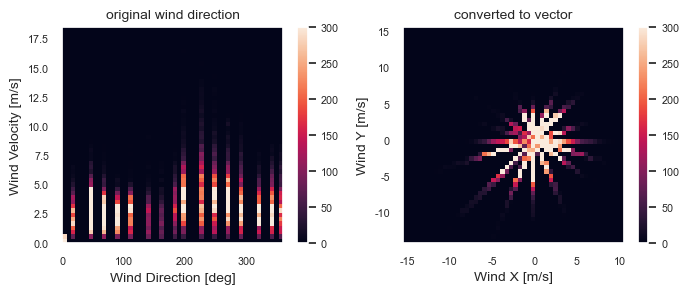

In [ ]:
font = {'size'   : 10}
plt.rc('font', **font)
sns.set(font_scale=0.7)

plt.figure(figsize = (7, 3))
plt.subplot(1, 2, 1) 
plt.hist2d(asos_data_graph['wd'], asos_data_graph['ws'], bins=(50, 50), vmax=300)
plt.colorbar()
plt.xlabel('Wind Direction [deg]', fontsize = 10)
plt.ylabel('Wind Velocity [m/s]', fontsize = 10)
plt.title('original wind direction', fontsize = 10)

plt.subplot(1, 2, 2) 
plt.hist2d(asos_data['wind_x'], asos_data['wind_y'], bins=(50,50), vmax=300)
plt.colorbar()
plt.xlabel('Wind X [m/s]', fontsize = 10)
plt.ylabel('Wind Y [m/s]', fontsize = 10)
plt.title('converted to vector', fontsize = 10)

plt.tight_layout()
plt.show()

In [ ]:
asos_data = asos_data.reset_index().drop('index', axis = 1)
# 2019년부터 2021년까지 데이터 이용
asos_data = asos_data[asos_data['date'].astype(str).str[:4].apply(lambda x : int(x)) >= 2019].reset_index().drop('index', axis = 1)
asos_data.head(3)

,date,tem,rain,hum,vapor,dew,press,cloud,wind_x,wind_y
0,2019-01-01 00:00:00,2.1,0.0,25.0,1.8,-15.9,1022.5,3.0,1.778505,-4.886402
1,2019-01-01 01:00:00,1.0,0.0,25.0,1.6,-16.8,1022.8,0.0,1.641697,-4.510525
2,2019-01-01 02:00:00,-0.1,0.0,26.0,1.6,-17.3,1022.3,0.0,3.753618,-3.149659


In [ ]:
air_data.shape, asos_data.shape

((26304, 10), (26304, 10))

In [ ]:
asos_data['측정일시'] = air_data['측정일시']
asos_date_time = asos_data['date'].apply(lambda x : str(x)[11:13])
asos_data['측정일시'].astype(str).str[:-2] + asos_date_time

0        2019010100
1        2019010101
2        2019010102
3        2019010103
4        2019010104
            ...    
26299    2021123119
26300    2021123120
26301    2021123121
26302    2021123122
26303    2021123123
Length: 26304, dtype: object

In [ ]:
asos_data['측정일시'] = asos_data['측정일시'].astype(str).str[:-2] + asos_date_time

##### 변수 결합

In [ ]:
vocs_df.columns

Index(['월', '일', '시간', '암모니아\n(ppb)', '톨루엔\n(ppb)', 'mp-자일렌(ppb)',
       'o-자일렌(ppb)', '자일렌(ppb)', '메틸에틸케톤(ppb)', '벤젠(ppb)', '연'],
      dtype='object')

In [ ]:
vocs_df.columns = ['month','date','hour','ammonia','toluen','mp-xylen','o-xylen','xylen','methyle','benzene', 'year']

In [ ]:
vocs_df.head(3)

,month,date,hour,ammonia,toluen,mp-xylen,o-xylen,xylen,methyle,benzene,year
0,1,1,0,76.1,2.8,0.8,0.3,1.1,0,0.4,2019
1,1,1,1,72.5,2.6,0.5,0.2,0.7,0,0.4,2019
2,1,1,2,70.1,2.5,0.5,0.2,0.7,0,0.4,2019


In [ ]:
vocs_df['month'] = vocs_df['month'].apply(lambda x : str(x).zfill(2))
vocs_df['date'] = vocs_df['date'].apply(lambda x : str(x).zfill(2))
vocs_df['hour'] = vocs_df['hour'].apply(lambda x : str(x).zfill(2))

In [ ]:
vocs_df['날짜'] = vocs_df['year'].astype(str) + vocs_df['month'] + \
                    vocs_df['date'] + vocs_df['hour']

In [ ]:
air_data.shape, asos_data.shape, vocs_df.shape

((26304, 10), (26304, 11), (26304, 12))

In [ ]:
vocs_df

,month,date,hour,ammonia,toluen,mp-xylen,o-xylen,xylen,methyle,benzene,year,날짜
0,01,01,00,76.1,2.8,0.8,0.3,1.1,0,0.4,2019,2019010100
1,01,01,01,72.5,2.6,0.5,0.2,0.7,0,0.4,2019,2019010101
2,01,01,02,70.1,2.5,0.5,0.2,0.7,0,0.4,2019,2019010102
3,01,01,03,67.5,2.5,0.5,0.2,0.7,0,0.4,2019,2019010103
4,01,01,04,68.8,1.5,0.4,0.1,0.6,0,0.4,2019,2019010104
...,...,...,...,...,...,...,...,...,...,...,...,...
26299,12,31,19,11.157,0.84,0.768,0.24,1.008,0,0.237,2021,2021123119
26300,12,31,20,11.448,6.626,3.246,0.862,4.108,0,0.229,2021,2021123120
26301,12,31,21,10.654,4.612,2.373,0.694,3.067,0,0.2,2021,2021123121
26302,12,31,22,10.94,12.346,7.197,1.826,9.023,0,0,2021,2021123122


In [ ]:
asos_data['측정일시'] = asos_data['측정일시'].astype(int)

In [ ]:
df_data = pd.concat([air_data, asos_data, vocs_df], axis = 1)
df_data.columns

Index(['측정일시', 'PM10', 'PM25', 'O3', 'NO2', 'SO2', 'year', 'mon', 'day',
       'hour', 'date', 'tem', 'rain', 'hum', 'vapor', 'dew', 'press', 'cloud',
       'wind_x', 'wind_y', '측정일시', 'month', 'date', 'hour', 'ammonia',
       'toluen', 'mp-xylen', 'o-xylen', 'xylen', 'methyle', 'benzene', 'year',
       '날짜'],
      dtype='object')

In [ ]:
df_data.drop(['측정일시', 'year', 'mon', 'day', 'hour', 'date', 'month'], axis = 1, inplace = True)
df_data.set_index('날짜', inplace = True)
df_data.head()

,PM10,PM25,O3,NO2,SO2,tem,rain,hum,vapor,dew,...,cloud,wind_x,wind_y,ammonia,toluen,mp-xylen,o-xylen,xylen,methyle,benzene
날짜,,,,,,,,,,,,,,,,,,,,,
2019010100,42.0,28.0,0.010,0.029,0.003,2.1,0.0,25.0,1.8,-15.9,...,3.0,1.778505,-4.886402,76.1,2.8,0.8,0.3,1.1,0,0.4
2019010101,36.0,23.0,0.013,0.024,0.003,1.0,0.0,25.0,1.6,-16.8,...,0.0,1.641697,-4.510525,72.5,2.6,0.5,0.2,0.7,0,0.4
2019010102,34.0,22.0,0.013,0.024,0.003,-0.1,0.0,26.0,1.6,-17.3,...,0.0,3.753618,-3.149659,70.1,2.5,0.5,0.2,0.7,0,0.4
2019010103,36.0,26.0,0.011,0.026,0.003,-0.9,0.0,28.0,1.6,-17.1,...,0.0,3.476863,-1.265475,67.5,2.5,0.5,0.2,0.7,0,0.4
2019010104,43.0,29.0,0.014,0.024,0.003,-1.2,0.0,31.0,1.7,-16.2,...,0.0,4.416555,-1.607495,68.8,1.5,0.4,0.1,0.6,0,0.4


In [ ]:
#데이터의 타입 확인
df_data.dtypes.value_counts()

float64    14
object      7
dtype: int64

In [ ]:
df_data.isnull().sum()

PM10         220
PM25         319
O3           502
NO2          564
SO2          375
tem            0
rain           0
hum            0
vapor          0
dew            0
press          0
cloud          0
wind_x         0
wind_y         0
ammonia     1107
toluen      1334
mp-xylen    1333
o-xylen     1333
xylen       1332
methyle     1332
benzene     2155
dtype: int64

In [ ]:
# toluen, mp-xylen, o-xylen, xylen, methyle은 모두 같은 날, 같은 시간에 측정값이 없음
# 따라서, 기계의 측정오류로 판단 8700개 데이터 중 600개를 삭제하기에는 많다고 판단하여
# 결측치를 intepolate을 이용해 채워줌

In [ ]:
#df_data의 전체 컬럼을 float형태로 변형
ob_col = [col for col in df_data.columns if df_data[col].dtype == 'O']
for ob in ob_col:
    df_data[ob] = df_data[ob].astype(float).interpolate(method = 'linear')

df_data.dtypes.value_counts()

float64    21
dtype: int64

In [ ]:
tomm_pm = df_data['PM25'][24:].reset_index()
tomm_pm

,날짜,PM25
0,2019010200,23.0
1,2019010201,24.0
2,2019010202,25.0
3,2019010203,35.0
4,2019010204,20.0
...,...,...
26275,2021123119,9.0
26276,2021123120,12.0
26277,2021123121,17.0
26278,2021123122,19.0


In [ ]:
df_tomm = df_data.copy().reset_index()
df_tomm['tomm_pm'] = tomm_pm['PM25']
df_tomm.head()

,날짜,PM10,PM25,O3,NO2,SO2,tem,rain,hum,vapor,...,wind_x,wind_y,ammonia,toluen,mp-xylen,o-xylen,xylen,methyle,benzene,tomm_pm
0,2019010100,42.0,28.0,0.010,0.029,0.003,2.1,0.0,25.0,1.8,...,1.778505,-4.886402,76.1,2.8,0.8,0.3,1.1,0.0,0.4,23.0
1,2019010101,36.0,23.0,0.013,0.024,0.003,1.0,0.0,25.0,1.6,...,1.641697,-4.510525,72.5,2.6,0.5,0.2,0.7,0.0,0.4,24.0
2,2019010102,34.0,22.0,0.013,0.024,0.003,-0.1,0.0,26.0,1.6,...,3.753618,-3.149659,70.1,2.5,0.5,0.2,0.7,0.0,0.4,25.0
3,2019010103,36.0,26.0,0.011,0.026,0.003,-0.9,0.0,28.0,1.6,...,3.476863,-1.265475,67.5,2.5,0.5,0.2,0.7,0.0,0.4,35.0
4,2019010104,43.0,29.0,0.014,0.024,0.003,-1.2,0.0,31.0,1.7,...,4.416555,-1.607495,68.8,1.5,0.4,0.1,0.6,0.0,0.4,20.0


In [ ]:
print(np.std(df_tomm['PM25']))

14.21609332406672


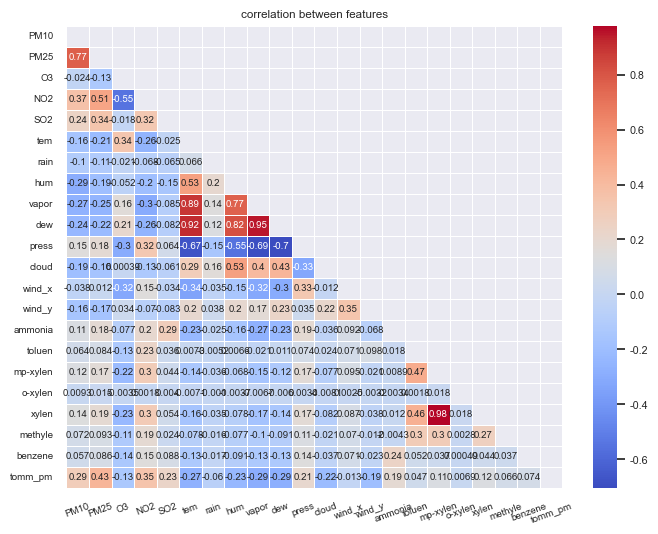

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=0.7)

plt.figure(figsize=(8, 6))
heat_map = df_tomm.corr()
mask = np.zeros_like(heat_map)
mask[np.triu_indices_from(mask)] =True
heatmap_ax = sns.heatmap(heat_map, annot=True, mask=mask, cmap='coolwarm', linewidths=.5, annot_kws={'size' :7})
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=7, rotation=20)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=7)
plt.title('correlation between features')
plt.show()

In [ ]:
air_data_a = pd.DataFrame(df_tomm.corr()['tomm_pm'])
air_data_a = abs(air_data_a)
air_data_a.sort_values(by = 'tomm_pm', inplace = True, ascending=False)

In [ ]:
air_data_a.T

,tomm_pm,PM25,NO2,PM10,vapor,dew,tem,hum,SO2,cloud,...,ammonia,O3,xylen,mp-xylen,benzene,methyle,rain,toluen,wind_x,o-xylen
tomm_pm,1.0,0.431793,0.348469,0.289708,0.289426,0.287533,0.274249,0.233675,0.232924,0.215737,...,0.185071,0.132465,0.124244,0.111726,0.074059,0.065963,0.060361,0.046701,0.013406,0.00691


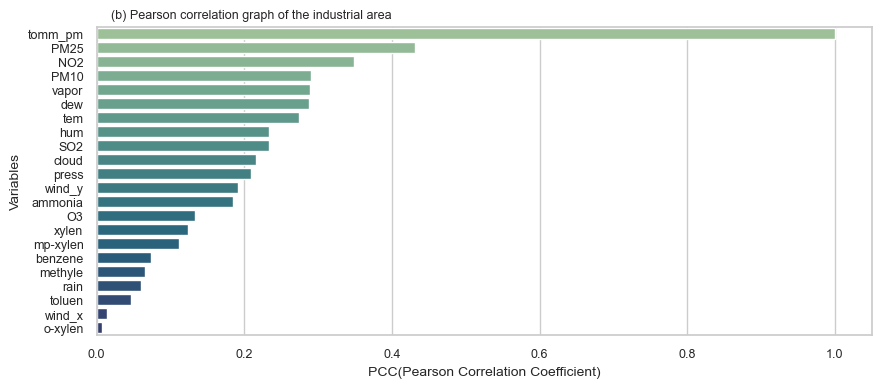

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,4))
sns.set(font_scale=1.1)
sns.set_style('whitegrid')
plt.xlabel('PCC(Pearson Correlation Coefficient)', fontsize = 10)
plt.ylabel('Variables', fontsize = 10)
plt.title('(b) Pearson correlation graph of the industrial area',
          position = (0.2, 1.01), fontsize = 9)
sns.set(font_scale=2)
sns.barplot(data = air_data_a.T, orient='h', palette = 'crest').tick_params(labelsize=9)